# Overview 

This is a basic exercise following the next link as a guide
https://www.kaggle.com/henriqueyamahata/bank-marketing-classification-roc-f1-recall

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

The variables were analyzed and different prediction methods were applied.
Some parts were simplified in comparison with the guide.

> To improve: It can be simplified more by adding a "pipeline" that does the whole process of transforming variables and standardization.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
data = pd.read_csv('/content/drive/MyDrive/BankMarketing/bank-additional-full.csv', sep = ';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
#Plot variables function
def plot_variables(variable, dist_subplot = False ):
  fig, ax = plt.subplots()
  fig.set_size_inches(15, 6)
  sns.countplot(x = variable, data = data)
  ax.set_xlabel(variable, fontsize=15)
  ax.set_ylabel('Count', fontsize=15)
  ax.set_title(variable + ' Count Distribution', fontsize=15)
  ax.tick_params(labelsize=15)
  sns.despine()

  if dist_subplot and data.dtypes[variable] != np.object:
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
    sns.boxplot(y = variable, data = data, orient = 'v', ax = ax1)
    ax1.set_ylabel(variable, fontsize=15)
    ax1.set_title(variable +' Distribution', fontsize=15)
    ax1.tick_params(labelsize=15)

    sns.histplot(data[variable], ax = ax2)
    sns.despine(ax = ax2)
    ax2.set_xlabel(variable, fontsize=15)
    ax2.set_ylabel('Occurence', fontsize=15)
    ax2.set_title(variable + ' x Ocucurence', fontsize=15)
    ax2.tick_params(labelsize=15)

    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout()
  elif dist_subplot: 
    print("Data type of " + variable + " is an object")


Data type of poutcome is an object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and

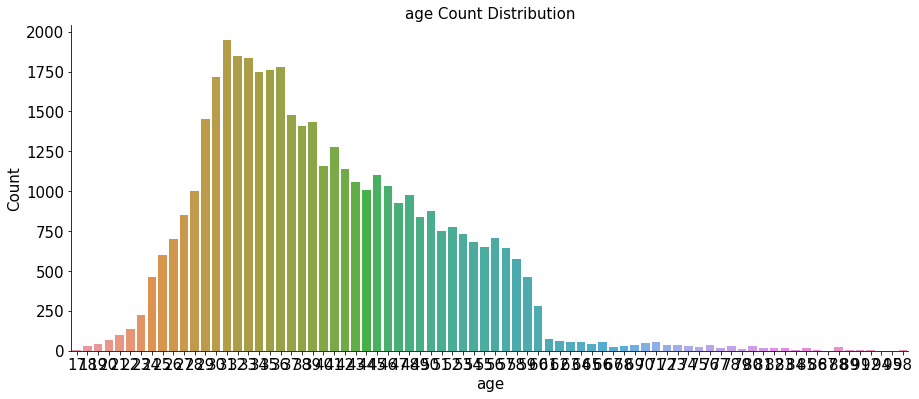

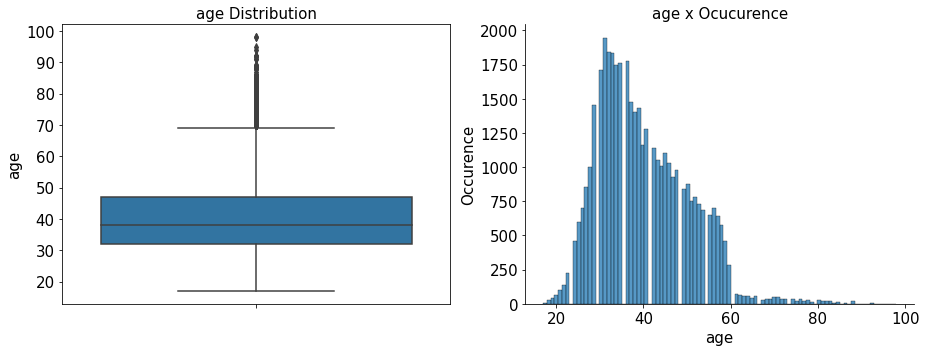

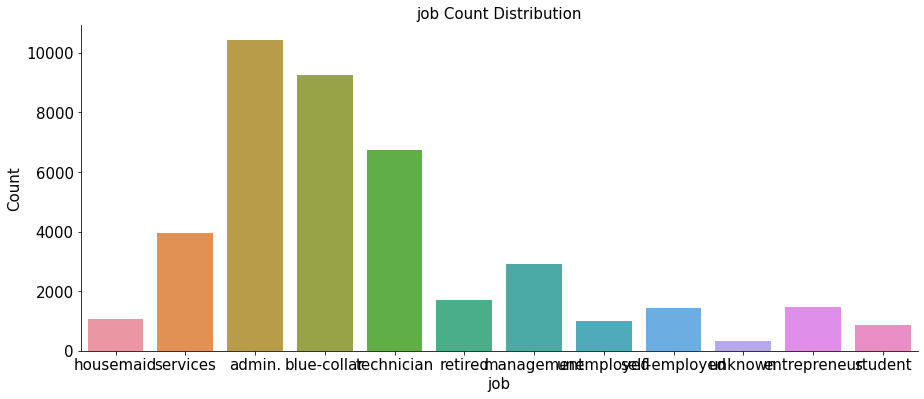

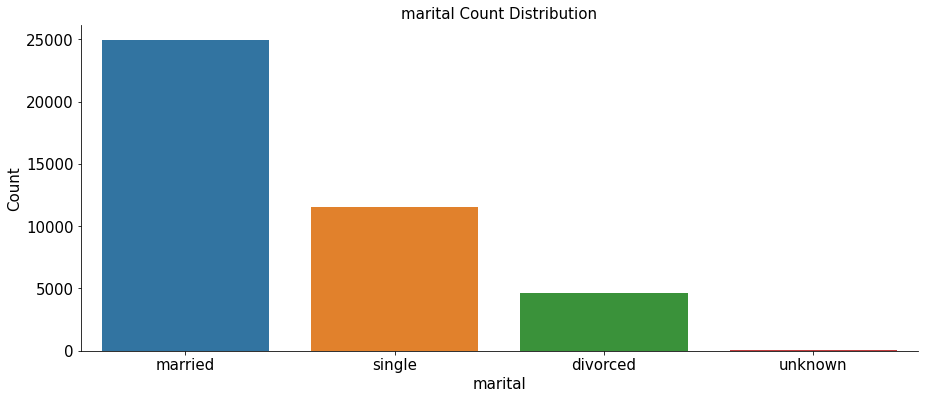

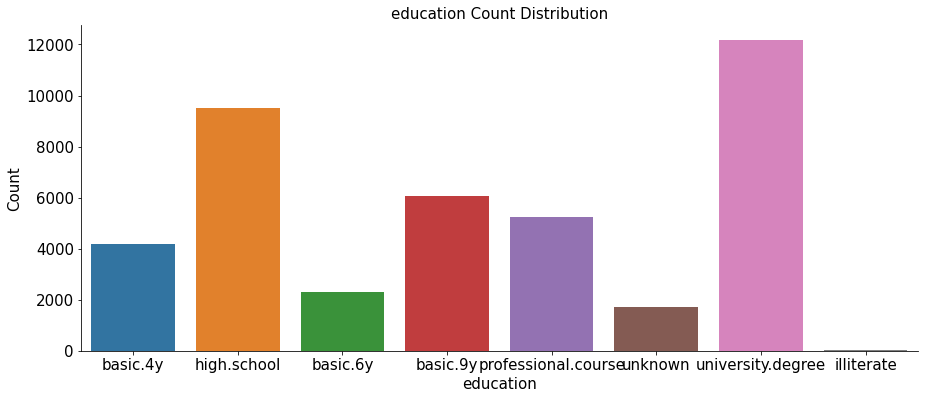

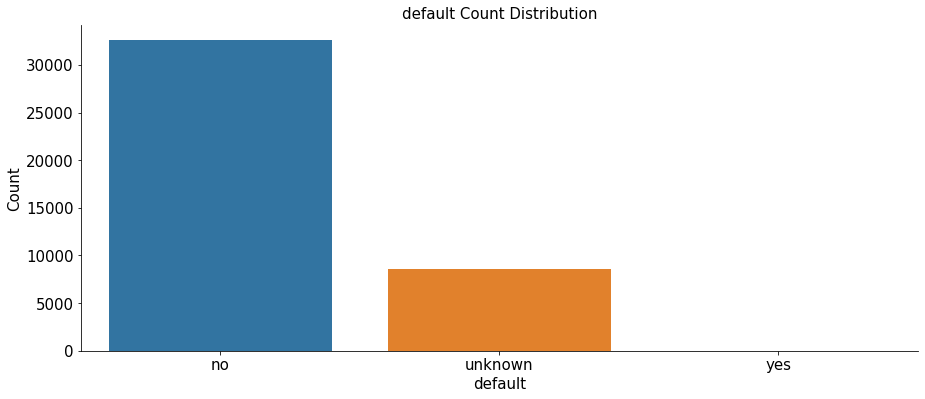

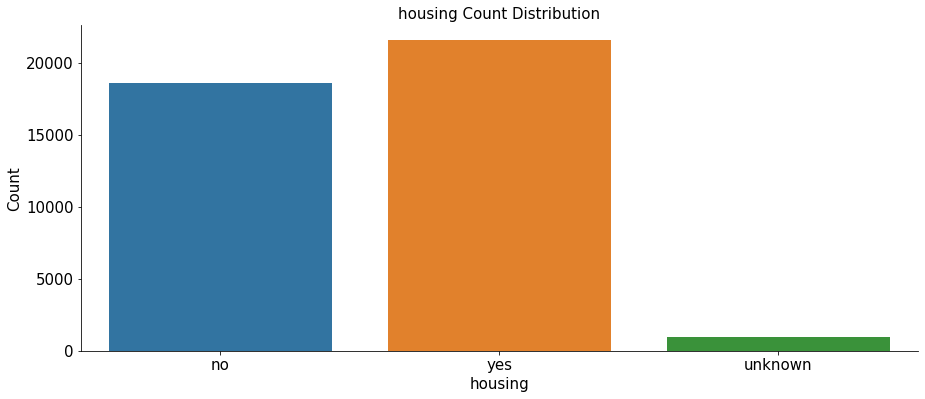

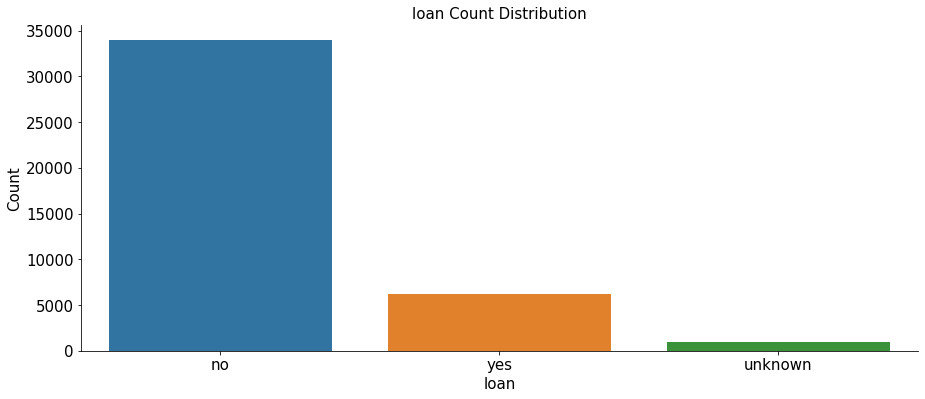

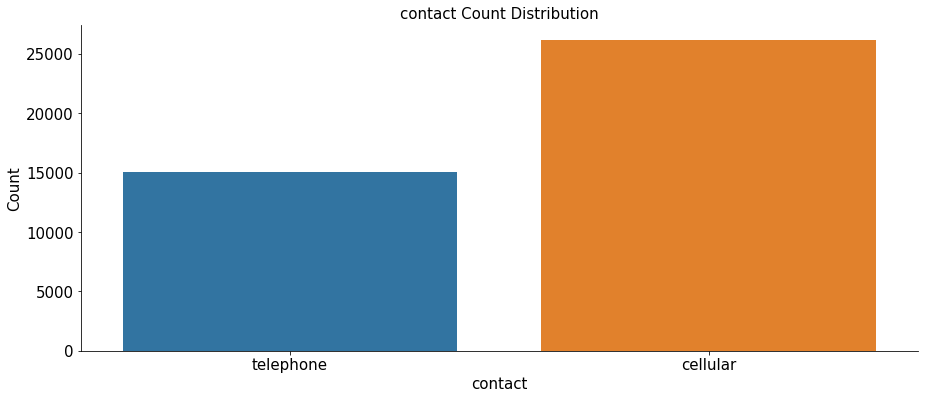

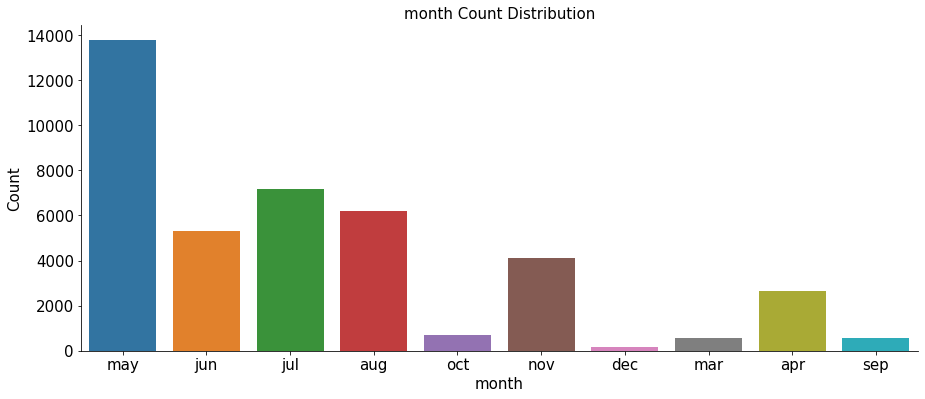

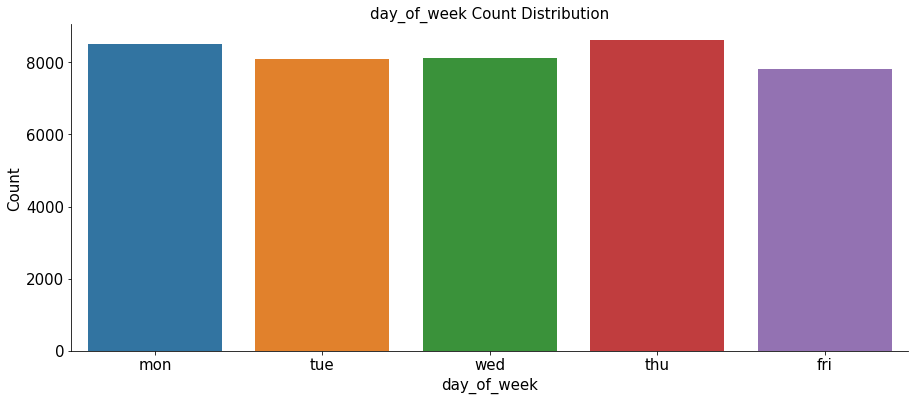

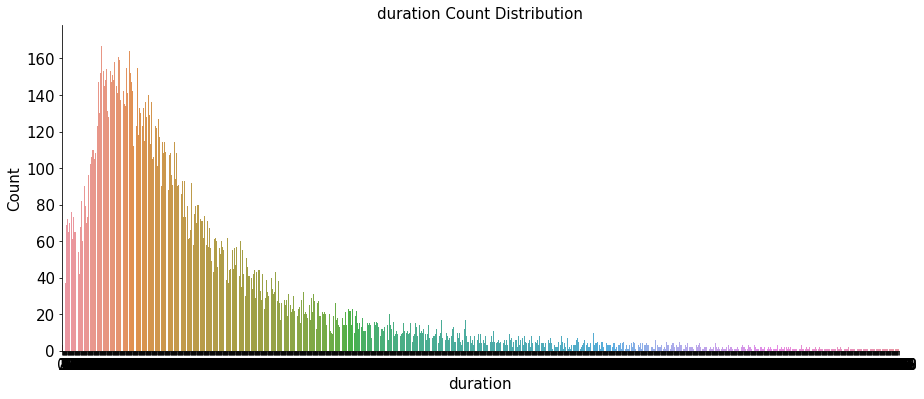

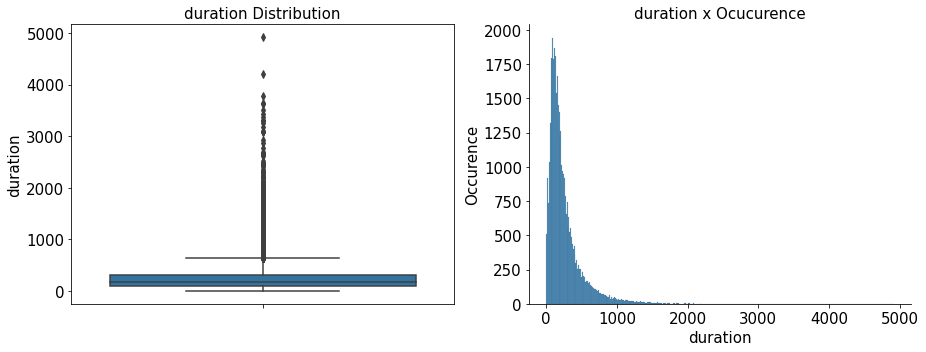

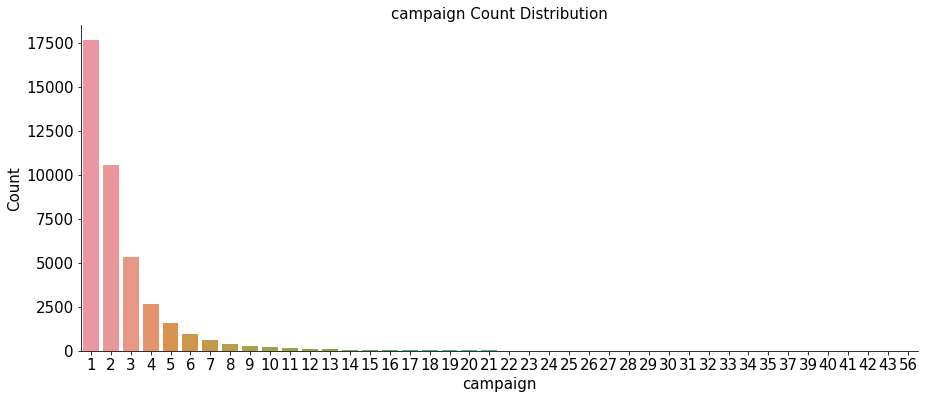

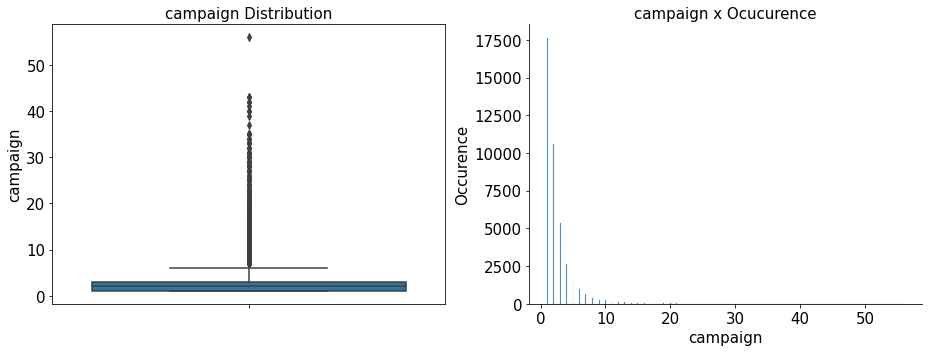

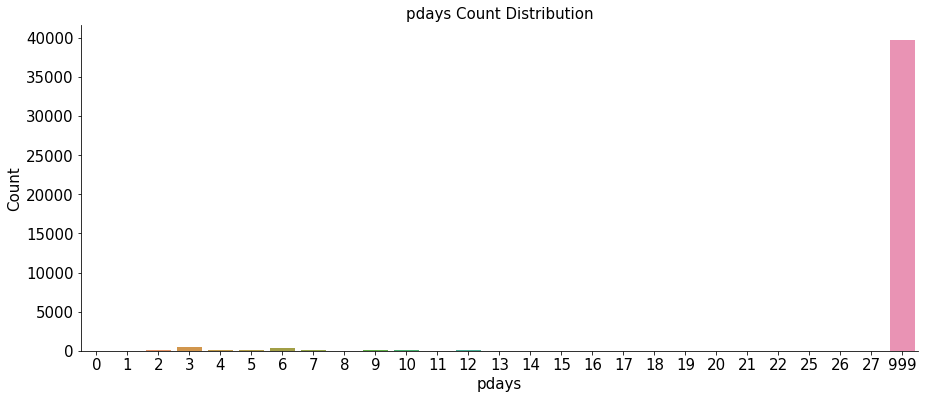

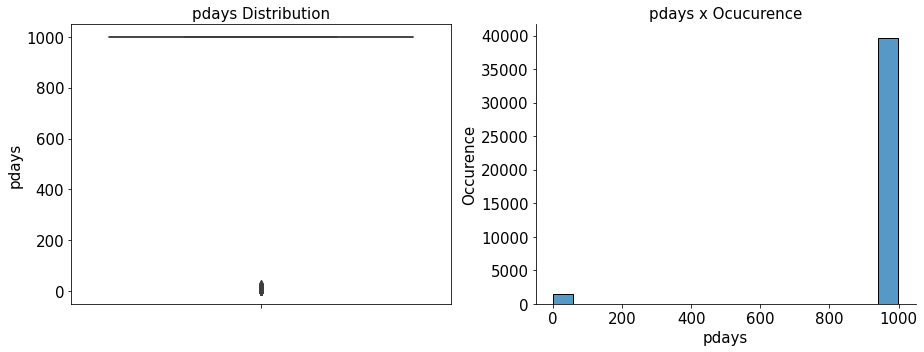

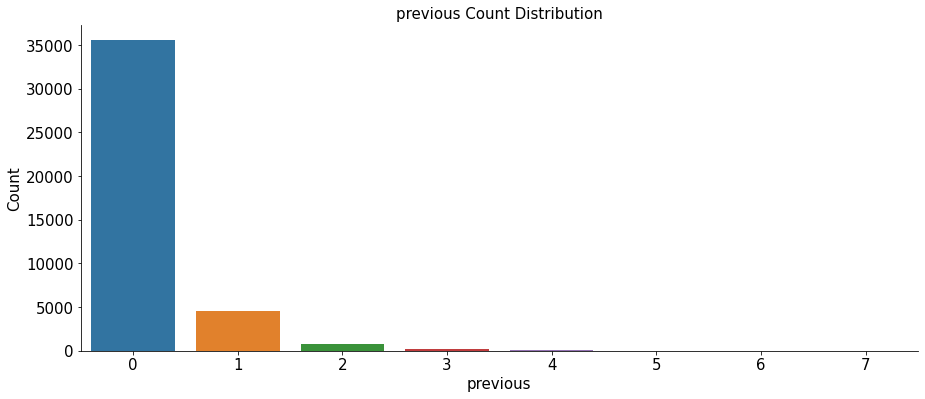

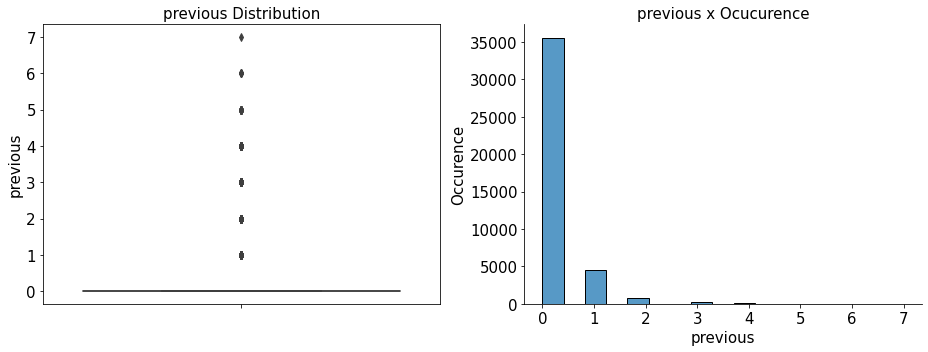

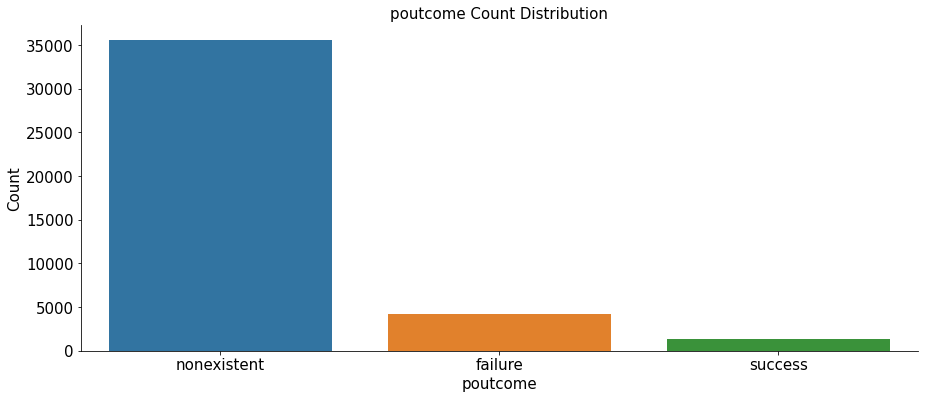

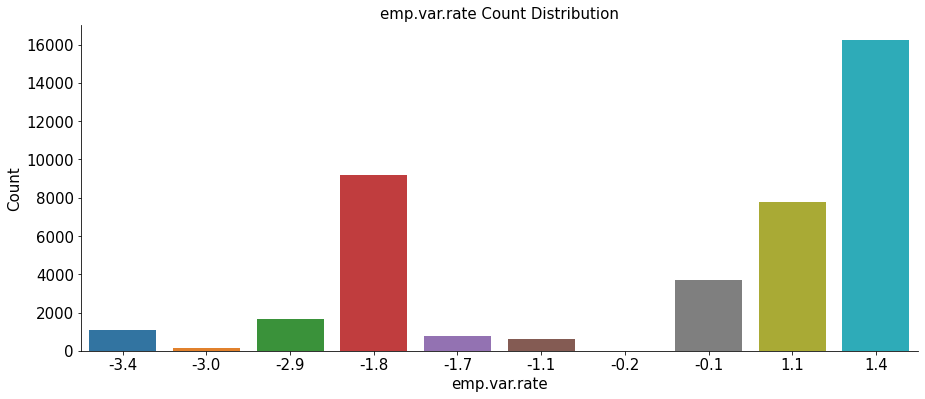

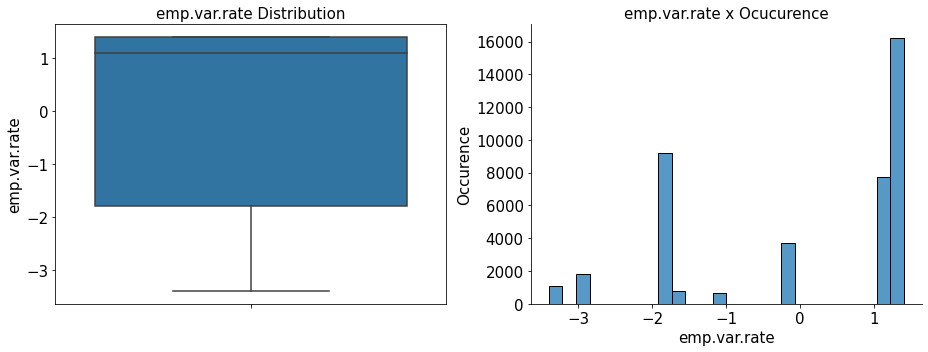

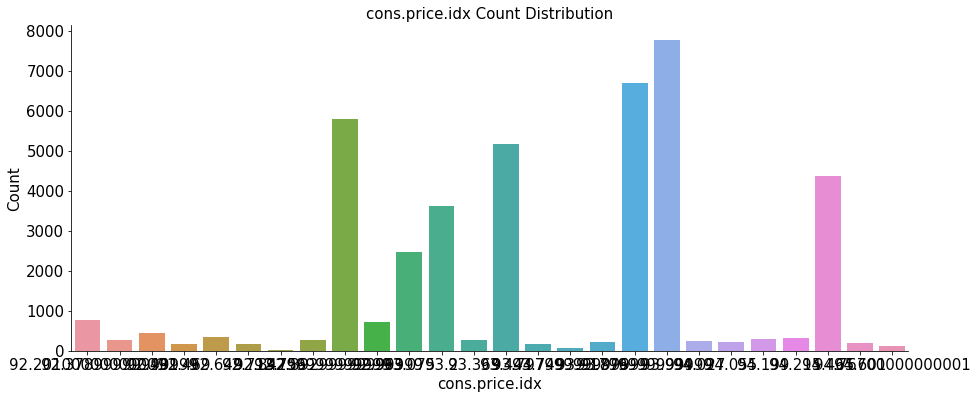

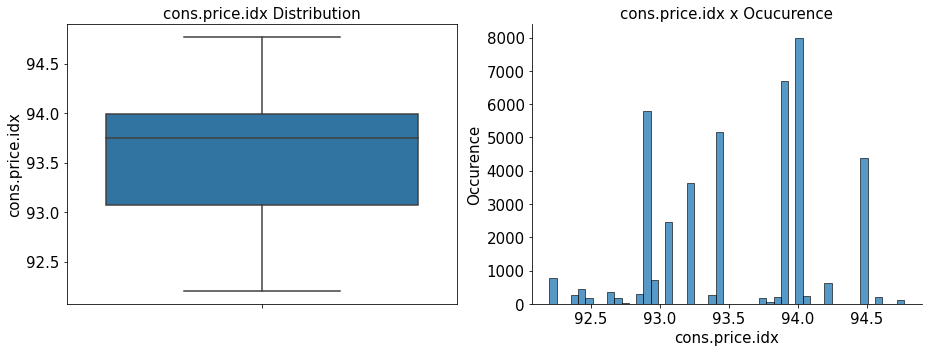

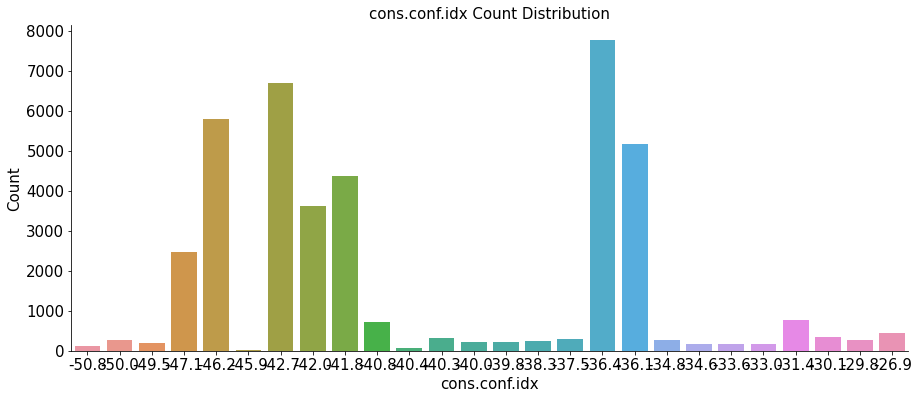

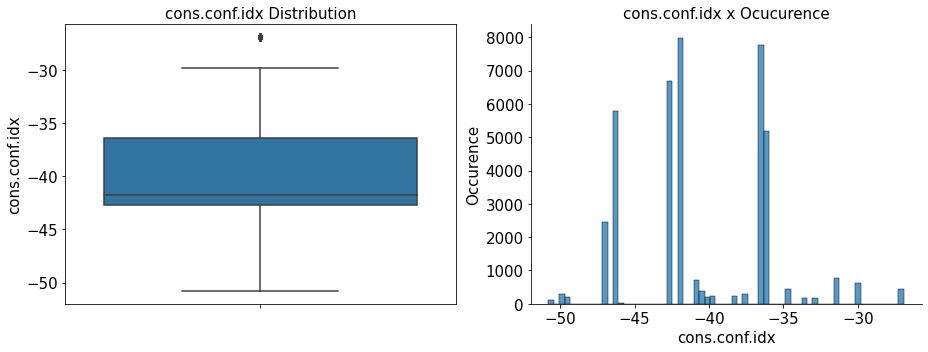

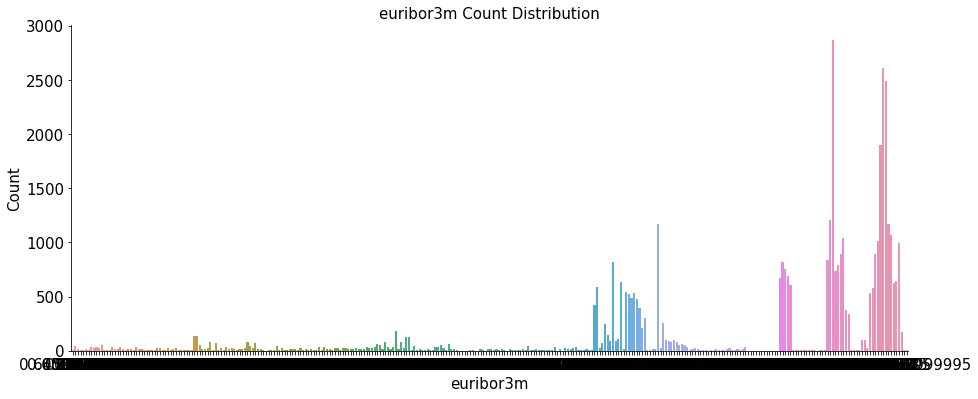

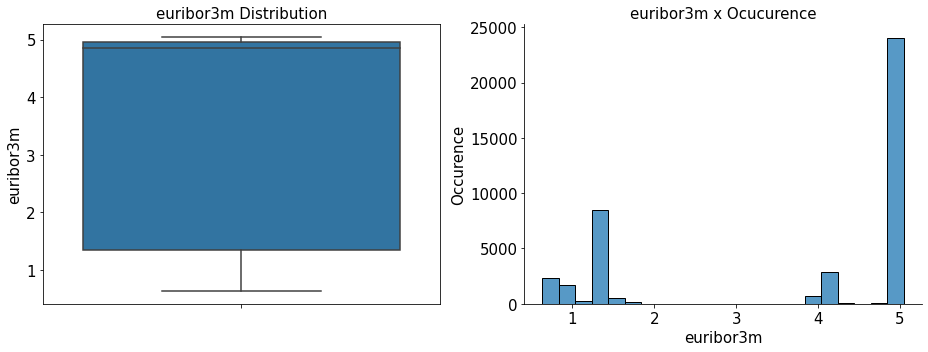

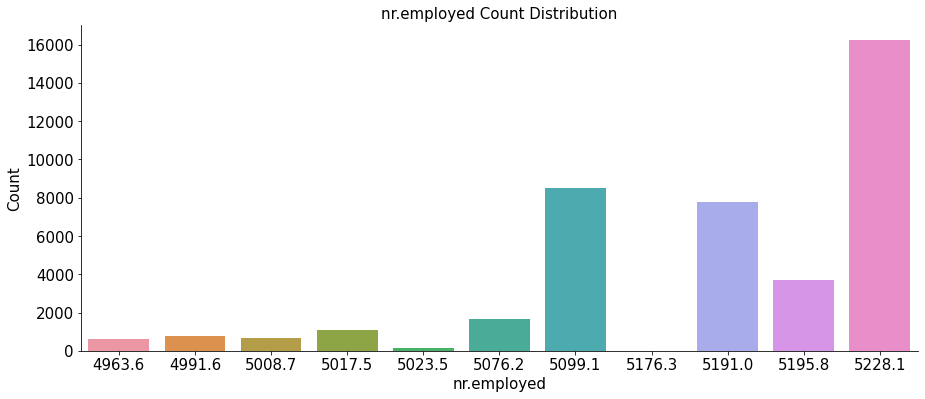

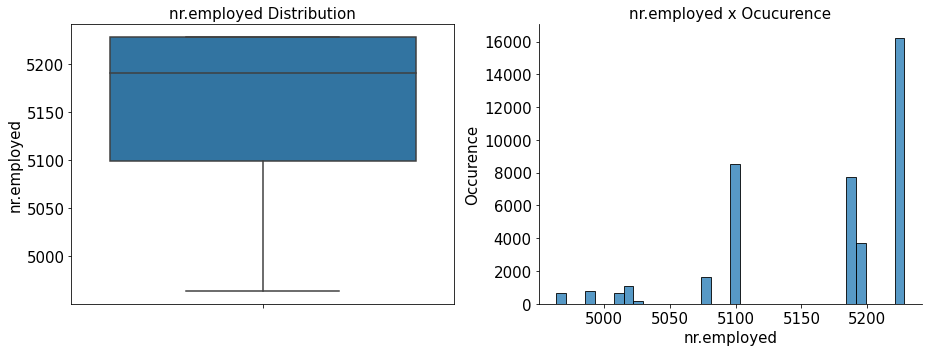

In [ ]:
#Data plot 

#age - it does not necessary split the age into diferents range sets like in the link guide  
plot_variables('age',True) 

#job       
plot_variables('job') 

#marital - most of the clients are married   
plot_variables('marital')

#education 
plot_variables('education')

#default      
plot_variables('default')

#housing       
plot_variables('housing')

#loan            
plot_variables('loan')

#contact - most by celular         
plot_variables('contact')

#month - principal month is MAY
plot_variables('month')

#day_of_week - there are not a big difference between the days values     
plot_variables('day_of_week')

#duration - call's duration less than 500 seconds        
plot_variables('duration',True)

#campaign        
plot_variables('campaign',True)

#pdays           
plot_variables('pdays',True)

#previous        
plot_variables('previous',True)

#poutcome        
plot_variables('poutcome')

#emp.var.rate    
plot_variables('emp.var.rate',True)

#cons.price.idx  
plot_variables('cons.price.idx',True)

#cons.conf.idx   
plot_variables('cons.conf.idx',True)

#euribor3m       
plot_variables('euribor3m',True)

#nr.employed     
plot_variables('nr.employed',True)


In [3]:
#Dependent variable 
encoder = OrdinalEncoder() 

#print(' categories:', data['y'].unique())
y = encoder.fit_transform(data[['y']])

In [4]:
#Transform categorical data to ordinal

dataObjects = data.select_dtypes(include=['object']).copy() # copy dataset objects
dataObjects = dataObjects.drop(columns=['y'])
encoder = OrdinalEncoder() 

for column in dataObjects.columns:
  #print(column + ' categories:', dataObjects[column].unique())
  dataObjects[column] = encoder.fit_transform(dataObjects[[column]])
  #print(column + ' ordinal:', dataObjects[column].unique())
  #print('\n')

dataObjects.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0
1,7.0,1.0,3.0,1.0,0.0,0.0,1.0,6.0,1.0,1.0
2,7.0,1.0,3.0,0.0,2.0,0.0,1.0,6.0,1.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,1.0,6.0,1.0,1.0
4,7.0,1.0,3.0,0.0,0.0,2.0,1.0,6.0,1.0,1.0


In [5]:
data_final = pd.concat([data.select_dtypes(exclude=['object']) ,dataObjects], axis = 1)

#Verify shape and data
data_final.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   duration        41188 non-null  int64  
 2   campaign        41188 non-null  int64  
 3   pdays           41188 non-null  int64  
 4   previous        41188 non-null  int64  
 5   emp.var.rate    41188 non-null  float64
 6   cons.price.idx  41188 non-null  float64
 7   cons.conf.idx   41188 non-null  float64
 8   euribor3m       41188 non-null  float64
 9   nr.employed     41188 non-null  float64
 10  job             41188 non-null  float64
 11  marital         41188 non-null  float64
 12  education       41188 non-null  float64
 13  default         41188 non-null  float64
 14  housing         41188 non-null  float64
 15  loan            41188 non-null  float64
 16  contact         41188 non-null  float64
 17  month           41188 non-null 

In [6]:
data_final.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,3.72458,1.172769,3.747184,0.208872,1.071720,0.327425,0.365252,4.230868,2.004613,0.930101
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,3.59456,0.608902,2.136482,0.406686,0.985314,0.723616,0.481507,2.320025,1.397575,0.362886
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.00000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,2.00000,1.000000,3.000000,0.000000,2.000000,0.000000,0.000000,4.000000,2.000000,1.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,7.00000,2.000000,6.000000,0.000000,2.000000,0.000000,1.000000,6.000000,3.000000,1.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,11.00000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,9.000000,4.000000,2.000000


In [ ]:
data_final.hist(bins=50, figsize=(20,15))

In [ ]:
corr_matrix = data_final.corr()

#Variables with a higher correlation value
plt.matshow(corr_matrix)
plt.show()
corr_matrix[['euribor3m','nr.employed', 'emp.var.rate']]

In [ ]:
#Note: Despite showing high correlation these three variables in a plot it does not see any correlation  
pd.plotting.scatter_matrix(data_final[['euribor3m','nr.employed', 'emp.var.rate']], figsize=(12,8))

In [7]:
#Get train dataset and test dataset
X_train, X_test, y_train, y_test = train_test_split(data_final, y, test_size = 0.2, random_state = 101)

In [8]:
#Create a list for cross validation methods 
CV_list = pd.DataFrame(columns = ['method','score'])

def update_cvlist(method, score):
  method_score = pd.DataFrame({'method': [method], 'score': [score]})
  if method in CV_list['method'].values :
    CV_list.update(method_score)
    return CV_list
  else:
    return CV_list.append(method_score, ignore_index=True)

In [9]:
#Standardize scales 
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

#Trainig models

In [ ]:
#Logistic regression
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train.ravel())
logpred = logmodel.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'Logistic regression', LOGCV )

[[7089  190]
 [ 583  376]]
91.0


In [ ]:
#Neighbors - The optimal number of neighbors

neighbors = np.arange(1,26)

cv_scores = []

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors = k, weights='uniform', p=2, metric='euclidean')
    kfold = KFold(n_splits=10, shuffle=True, random_state=123)
    scores = cross_val_score(knn, X_train, y_train.ravel(), cv=kfold, scoring='accuracy')
    cv_scores.append(scores.mean()*100)
    print("k=%d %0.2f (+/- %0.2f)" % (k, scores.mean()*100, scores.std()*100))

optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print ("The optimal number of neighbors is %d with %0.1f%%" % (optimal_k, cv_scores[optimal_k]))

plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Train Accuracy')
plt.show()

In [10]:
#K Neighbors Classifier

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train.ravel())
knnpred = knn.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, knnpred))
print(round(accuracy_score(y_test, knnpred),2)*100)
KNNCV = (cross_val_score(knn, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'KNeighbors', KNNCV )

[[7132  147]
 [ 666  293]]
90.0


In [ ]:
#SVC - Support Vector Machines

svc= SVC(kernel = 'sigmoid')
svc.fit(X_train, y_train.ravel())
svcpred = svc.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, svcpred))
print(round(accuracy_score(y_test, svcpred),2)*100)
SVCCV = (cross_val_score(svc, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'SVC', SVCCV )

[[6764  515]
 [ 561  398]]
87.0


In [ ]:
#Decision Tree 
dtree = DecisionTreeClassifier(criterion='gini')
dtree.fit(X_train, y_train.ravel())
dtreepred = dtree.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, dtreepred))
print(round(accuracy_score(y_test, dtreepred),2)*100)
DTREECV = (cross_val_score(dtree, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'Decision Tree', DTREECV )

[[6803  476]
 [ 476  483]]
88.0


In [ ]:
#Random Forest
rfc = RandomForestClassifier(n_estimators = 200)
rfc.fit(X_train, y_train.ravel())
rfcpred = rfc.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, rfcpred ))
print(round(accuracy_score(y_test, rfcpred),2)*100)
RFCCV = (cross_val_score(rfc, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'Random Forest', RFCCV )

[[7033  246]
 [ 468  491]]
91.0


In [ ]:
#Gaussian NB - Gaussian Naive Bayes
gaussiannb= GaussianNB()
gaussiannb.fit(X_train, y_train.ravel())
gaussiannbpred = gaussiannb.predict(X_test)
probs = gaussiannb.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, gaussiannbpred ))
print(round(accuracy_score(y_test, gaussiannbpred),2)*100)
GAUSIAN = (cross_val_score(gaussiannb, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'Gaussian NB', GAUSIAN )

[[6420  859]
 [ 392  567]]
85.0


In [ ]:
#XGB - eXtreme Gradient Boosting
xgb = XGBClassifier()
xgb.fit(X_train, y_train.ravel())
xgbprd = xgb.predict(X_test)

#Validate model
print(confusion_matrix(y_test, xgbprd ))
print(round(accuracy_score(y_test, xgbprd),2)*100)
XGB = (cross_val_score(estimator = xgb, X = X_train, y = y_train.ravel(), cv = 10).mean())*100

CV_list = update_cvlist( 'XGB', XGB )

[[7031  248]
 [ 489  470]]
91.0


In [14]:
#Gradient Boosting
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train.ravel())
gbkpred = gbk.predict(X_test)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Validate model
print(confusion_matrix(y_test, gbkpred ))
print(round(accuracy_score(y_test, gbkpred),2)*100)
GBKCV = (cross_val_score(gbk, X_train, y_train.ravel(), cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())*100

CV_list = update_cvlist( 'Gradient Boosting', GBKCV )

[[7029  250]
 [ 467  492]]
91.0


In [11]:
CV_list.sort_values(by='score', ascending=False)

,method,score
0,KNeighbors,90.467375


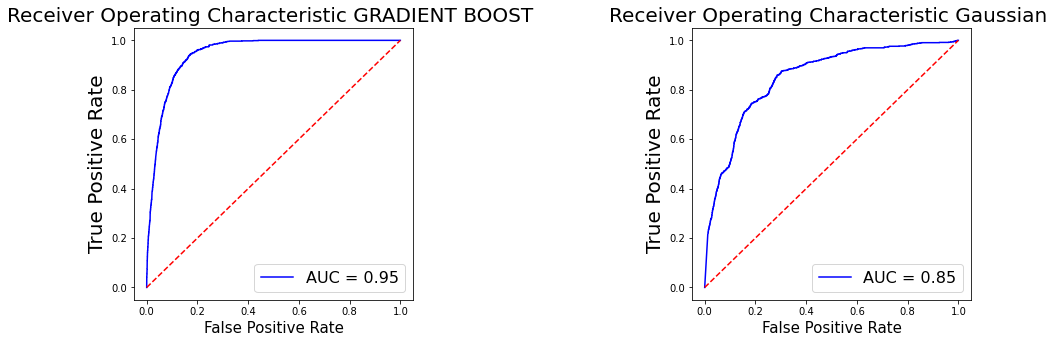

In [ ]:
#Accuracy is measured by the area under the ROC curve. An area of 1 represents a perfect test; an area of .5 represents a worthless test.
#Plot the best and the worst cross validation method.

fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

#The best: Gradient Boosting
probs = gbk.predict_proba(X_test)
preds = probs[:,1]
fprgbk, tprgbk, thresholdgbk = roc_curve(y_test, preds)
roc_aucgbk = auc(fprgbk, tprgbk)

ax.plot(fprgbk, tprgbk, 'b', label = 'AUC = %0.2f' % roc_aucgbk)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic GRADIENT BOOST ',fontsize=20)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

#The worst: Gaussian NB
probs = gaussiannb.predict_proba(X_test)
preds = probs[:,1]
fprgau, tprgau, thresholdgau = roc_curve(y_test, preds)
roc_aucgau = auc(fprgau, tprgau)

ax1.plot(fprgau, tprgau, 'b', label = 'AUC = %0.2f' % roc_aucgau)
ax1.plot([0, 1], [0, 1],'r--')
ax1.set_title('Receiver Operating Characteristic Gaussian ',fontsize=20)
ax1.set_ylabel('True Positive Rate',fontsize=20)
ax1.set_xlabel('False Positive Rate',fontsize=15)
ax1.legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=1)

#Final

In the guide link, they decided the optimal model is KNeighborsClassifier due to a big false positive value in the confusion matrix means the client do NOT SUBSCRIBED to term deposit, but the model thinks he did. So they found the best model by confusion matrix with the lowest False Positive as possible.

If we compare the acurracy and peroformance of the models, there is not much difference between the GRADIENT BOOST and the K Neighbors Classifier. Although the KNN is chosen only for the low false positives values.I think that the false positives values in other models could be reduced by modifying some parameters. 

> To review the teory and how to calculate the values in the clasification report, we use the Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (Second edition) by Aurélien Géron, pages 139 to 141 also the teory for all clasification models.

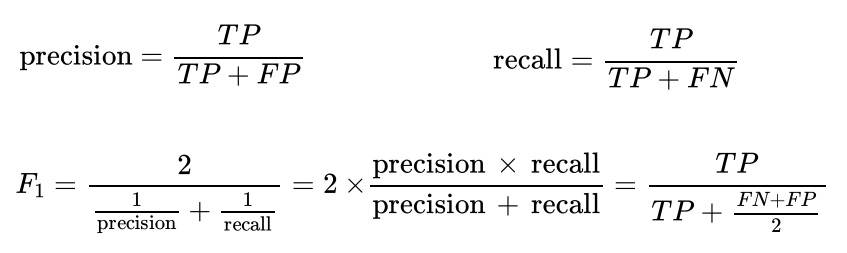


In [16]:
print('KNN Reports\n',classification_report(y_test, knnpred))
print('\n')
print('Gradient Boosting Reports\n',classification_report(y_test, gbkpred))

KNN Reports
               precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      7279
         1.0       0.67      0.31      0.42       959

    accuracy                           0.90      8238
   macro avg       0.79      0.64      0.68      8238
weighted avg       0.89      0.90      0.88      8238



Gradient Boosting Reports
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      7279
         1.0       0.66      0.51      0.58       959

    accuracy                           0.91      8238
   macro avg       0.80      0.74      0.76      8238
weighted avg       0.91      0.91      0.91      8238

